## Devanagiri Character Recognition using Convolutional Neural Networks

### Devangiri Characters		


<table>
<tr><th><th>Consonants<th><th>Digits</th></tr>
<tr><td>

| Character 	| Label        	| Class 	|
|-----------	|--------------	|-------	|
| क         	| ka           	| 0     	|
| ख         	| kha          	| 1     	|
| ग         	| ga           	| 2     	|
| घ         	| gha          	| 3     	|
| ङ         	| kna          	| 4     	|
| च         	| cha          	| 5     	|
| छ         	| chha         	| 6     	|
| ज         	| ja           	| 7     	|
| झ         	| jha          	| 8     	|
| ञ         	| yna          	| 9     	|
| ट         	| ta           	| 10    	|
| ठ         	| tha          	| 11    	|

</td><td>

| Character 	| Label        	| Class 	|
|-----------	|--------------	|-------	|
| ड         	| da           	| 12    	|
| ढ         	| dha          	| 13    	|
| ण         	| ana          	| 14    	|
| त         	| taa          	| 15    	|
| थ         	| thaa         	| 16    	|
| द         	| daa          	| 17    	|
| ध         	| dhaa         	| 18    	|
| न         	| na           	| 19    	|
| प         	| pa           	| 20    	|
| फ         	| pha          	| 21    	|
| ब         	| ba           	| 22    	|
| भ         	| bha          	| 23    	|

</td><td>
    
| Character 	| Label        	| Class 	|
|-----------	|--------------	|-------	|
| म         	| ma           	| 24    	|
| य         	| ya           	| 25    	|
| र         	| ra           	| 26    	|
| ल         	| la           	| 27    	|
| व         	| va           	| 28    	|
| श         	| motosaw      	| 29    	|
| ष         	| petchiryosaw 	| 30    	|
| स         	| patalosaw    	| 31    	|
| ह         	| ha           	| 32    	|
| क्ष        	| ksha         	| 33    	|
| त्र        	| tra          	| 34    	|
| ज्ञ        	| gya          	| 35    	|

</td><td>
    
| Character 	| Label        	| Class 	|
|-----------	|--------------	|-------	|
| ०         	| 0            	| 36    	|
| १         	| 1            	| 37    	|
| २         	| 2            	| 38    	|
| ३         	| 3            	| 39    	|
| ४         	| 4            	| 40    	|
| ५         	| 5            	| 41    	|
| ६         	| 6            	| 42    	|
| ७         	| 7            	| 43    	|
| ८         	| 8            	| 44    	|
| ९         	| 9            	| 45    	|

</td></tr> </table>


In [98]:
devchar = {0: "क",
           1: "ख",
           2:"ग",
           3:"घ",
           4:"ङ",
           5:"च",
           6:"छ",
           7:"ज",
           8:"झ",
           9:"ञ",
           10:"ट",
           11:"ठ",
           12:"ड",
           13:"ढ",
           14:"ण",
           15:"त",
           16:"थ",
           17:"द",
           18:"ध",
           19:"न",
           20:"प",
           21:"फ",
           22:"ब",
           23:"भ",
           24:"म",
           25:"य",
           26:"र",
           27:"ल",
           28:"व",
           29:"श",
           30:"ष",
           31:"स",
           32:"ह",
           33:"क्ष",
           34:"त्र",
           35:"ज्ञ",
           36:"०",
           37:"१",
           38:"२",
           39:"३",
           40:"४",
           41:"५",
           42:"६",
           43:"७",
           44:"८",
           45:"९",}

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import re
from PIL import Image as PImage

from datetime import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [57]:
def y2indicator(Y):
    N = len(Y)
    K = len(set(Y))
    Y_ind = np.zeros((N,K))
    for i in range(N):
        Y_ind[i,Y[i]] = 1
    return Y_ind

def error_rate(targets,predictions):
    return np.mean(targets != predictions)

def convpool(X,W,b):
    conv_out = tf.nn.conv2d(X, W, strides = [1,1,1,1], padding = 'VALID')
    conv_out = tf.nn.bias_add(conv_out, bias = b)
    pool_out = tf.nn.max_pool(conv_out, ksize = [1,2,2,1], strides= [1,2,2,1], padding='VALID')
    return tf.nn.relu(pool_out)

def init_filter(shape):
    W = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
    return W.astype(np.float32)

def init_weight_and_bias(M1,M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

### About the dataset

There are 46 classes of characters with 1700 examples each. The dataset is split into training set (85% - 78200 samples) and testing set (15% - 13800 samples).

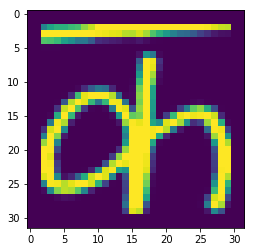

In [3]:
img = mpimg.imread("../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_1_ka/1340.png")
plt.imshow(img)
plt.show()

In [4]:
img.shape

(32, 32)

In [5]:
x = img.reshape((img.shape[0],img.shape[1],1))

In [6]:
x.shape

(32, 32, 1)

### Data Pre-processing

Note: Only run the **Data Preprocessing** section once to generate and save the processed training (Xtrain, Ytrain) and test (Xtest, Ytest) *.npy* files.

#### Load Images as numpy arrays

In [7]:
# For sorting alphabetically
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def loadImages(path):
    # return array of images
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        
        with PImage.open(path + image) as img:
            img = np.array(img)
            img = img.reshape((img.shape[0],img.shape[1],1))
            loadedImages.append(img)

    return loadedImages

def show_image(image):
    # Plots image
    assert len(image.shape) == 3, "Image passed in is of incorrect shape"
    plt.imshow(image.squeeze())
    plt.show()


traindir = "../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/"
testdir = "../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/"

# Get all subdirs of train dir
train_subdirs = [traindir + i + '/' for i in os.listdir(traindir)]
train_subdirs.sort(key=natural_keys) # Sorting character folder names by their number via Human/Natural Sorting

# Get all subdirs of test dir
test_subdirs = [testdir + i + '/' for i in os.listdir(testdir)]
test_subdirs.sort(key=natural_keys) # Sorting character folder names by their number via Human/Natural Sorting

train_images = []
test_images = []

for path in train_subdirs:
    print("Extracting characters from ",path)
    tr_imgs = loadImages(path)
    train_images.append(tr_imgs)

print("\n")
    
for path in test_subdirs:
    print("Extracting characters from ",path)
    te_imgs = loadImages(path)
    test_images.append(te_imgs)


Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_1_ka/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_2_kha/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_3_ga/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_4_gha/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_5_kna/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_6_cha/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_7_chha/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Train/character_8_ja/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharact

Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_27_ra/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_28_la/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_29_waw/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_30_motosaw/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_31_petchiryakha/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_32_patalosaw/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_33_ha/
Extracting characters from  ../large_files/Devanagiri/DevanagariHandwrittenCharacterDataset/Test/character_34_chhya/
Extracting characters from  ../large_files/Devanagiri/Devanaga

Now we have the array images which is a 2D list that contains the 1700 unique writings of the 46 Devanagiri characters. Each of the 1700 images has been reshaped from its original 32 x 32 size to a numpy array of size 32 x 32 x 1 where 1 represents the number of colour channels. The 1 here indicates it's a greyscale image.

images - Characters - list <br>
images[i] - Handwritings per character - list <br>
images[i][j] - Image of handwriting - numpy array <br>

In [8]:
print(len(train_images))
print(len(test_images))

46
46


In [9]:
print(len(train_images[0]))
print(len(test_images[0]))

1700
300


In [10]:
print(type(train_images[0][0]))
print(type(test_images[0][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
print(train_images[0][0].shape)
print(test_images[0][0].shape)

(32, 32, 1)
(32, 32, 1)


#### Make Labels

In [15]:
Ytrain = []
for i in range(len(train_images)):
    for j in range(len(train_images[i])):
        Ytrain.append(i)
Ytrain = np.array(Ytrain)
    

Ytest = []
for i in range(len(test_images)):
    for j in range(len(test_images[i])):
        Ytest.append(i)
Ytest = np.array(Ytest)

#### Concatenate data

In [19]:
Xtrain = []
for i in range(len(train_images)):
    for j in range(len(train_images[i])):
        Xtrain.append(train_images[i][j])
Xtrain = np.array(Xtrain)

Xtest = []
for i in range(len(train_images)):
    for j in range(len(test_images[i])):
        Xtest.append(test_images[i][j])
Xtest = np.array(Xtest)

In [20]:
print("Shape of Xtrain = ",Xtrain.shape)
print("Shape of Xtest = ",Xtest.shape)
print("Shape of Ytrain = ",Ytrain.shape)
print("Shape of Ytest = ",Ytest.shape)

Shape of Xtrain =  (78200, 32, 32, 1)
Shape of Xtest =  (13800, 32, 32, 1)
Shape of Ytrain =  (78200,)
Shape of Ytest =  (13800,)


In [30]:
# Normalise Data
Xtrain = Xtrain / 255
Xtest = Xtest / 255

#### Saving Pre-processed Data 

In [31]:
np.save('Xtrain.npy', Xtrain)
np.save('Xtest.npy', Xtest)
np.save('Ytrain.npy', Ytrain)
np.save('Ytest.npy', Ytest)

### Model Building

In [33]:
# Load training Data
X = np.load('Xtrain.npy')
Y = np.load('Ytrain.npy')

In [36]:
# Train Test Split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=42)

In [43]:
# Get indicator variables
Y_train_ind = y2indicator(Y_train)
Y_valid_ind = y2indicator(Y_valid)

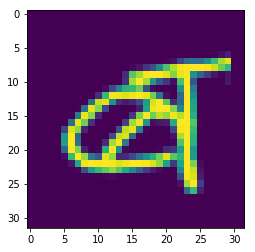

Corresponding Label =  22
Corresponding Character =  ब


In [103]:
# Viewing the Devanagiri characters from the training set and their corresponding labels
im = 1
show_image(X_train[im])
print("Corresponding Label = ",Y_train[im])
print("Corresponding Character = ",devchar[Y_train[im]])

In [45]:
X_train.shape

(54740, 32, 32, 1)

In [46]:
Y_train_ind.shape

(54740, 46)

#### Building and Training the Network

Cost / err at iteration i=0, j=0: 89374.461 / 0.964
Cost / err at iteration i=0, j=10: 84483.565 / 0.852
Cost / err at iteration i=0, j=20: 63265.424 / 0.721
Cost / err at iteration i=0, j=30: 41018.942 / 0.505
Cost / err at iteration i=0, j=40: 27519.201 / 0.348
Cost / err at iteration i=0, j=50: 21195.199 / 0.274
Cost / err at iteration i=0, j=60: 17074.170 / 0.228
Cost / err at iteration i=0, j=70: 14548.750 / 0.194
Cost / err at iteration i=0, j=80: 13315.504 / 0.181
Cost / err at iteration i=0, j=90: 11566.471 / 0.158
Cost / err at iteration i=1, j=0: 10825.915 / 0.149
Cost / err at iteration i=1, j=10: 10066.752 / 0.143
Cost / err at iteration i=1, j=20: 9940.145 / 0.142
Cost / err at iteration i=1, j=30: 9421.448 / 0.137
Cost / err at iteration i=1, j=40: 8600.336 / 0.122
Cost / err at iteration i=1, j=50: 8051.647 / 0.115
Cost / err at iteration i=1, j=60: 7763.631 / 0.111
Cost / err at iteration i=1, j=70: 8312.553 / 0.119
Cost / err at iteration i=1, j=80: 6774.780 / 0.099
Co

Cost / err at iteration i=15, j=70: 8303.307 / 0.068
Cost / err at iteration i=15, j=80: 7062.927 / 0.065
Cost / err at iteration i=15, j=90: 6550.802 / 0.062
Cost / err at iteration i=16, j=0: 7061.376 / 0.064
Cost / err at iteration i=16, j=10: 6804.331 / 0.065
Cost / err at iteration i=16, j=20: 6554.082 / 0.063
Cost / err at iteration i=16, j=30: 8195.938 / 0.074
Cost / err at iteration i=16, j=40: 6966.380 / 0.068
Cost / err at iteration i=16, j=50: 7066.297 / 0.072
Cost / err at iteration i=16, j=60: 7270.636 / 0.069
Cost / err at iteration i=16, j=70: 8423.226 / 0.071
Cost / err at iteration i=16, j=80: 7322.121 / 0.065
Cost / err at iteration i=16, j=90: 6968.938 / 0.066
Cost / err at iteration i=17, j=0: 6950.387 / 0.065
Cost / err at iteration i=17, j=10: 7177.585 / 0.067
Cost / err at iteration i=17, j=20: 7162.780 / 0.064
Cost / err at iteration i=17, j=30: 7647.607 / 0.070
Cost / err at iteration i=17, j=40: 7546.986 / 0.071
Cost / err at iteration i=17, j=50: 7301.096 / 0

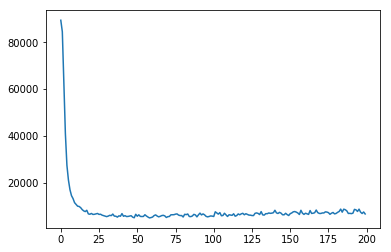

Final Test Accuracy =  94.225 %


In [92]:
# Gradient descent params

N = X_train.shape[0]
M = 500
K = len(set(Y_train))

epochs = 20
print_period = 10
batch_sz = 595
n_batches = N // batch_sz
reg = 0.001

# Initialise Variables
W1_shape = (5,5,1,10) # (HWFinFout)
W1_init = init_filter(W1_shape)
b1_init = np.zeros(W1_shape[-1],dtype=np.float32)

W2_shape = (5,5,10,30) # (HWFinFout)
W2_init = init_filter(W2_shape)
b2_init = np.zeros(W2_shape[-1],dtype=np.float32)

W3_init, b3_init = init_weight_and_bias(W2_shape[-1]*5*5,M)

W4_init, b4_init = init_weight_and_bias(M,K)

# Set Placeholders & Variables 

tfX = tf.placeholder(dtype=tf.float32,shape=(batch_sz,32,32,1),name="X")
tfT = tf.placeholder(dtype=tf.float32,shape=(batch_sz,K),name="T")

W1 = tf.Variable(initial_value=W1_init,dtype=tf.float32)
b1 = tf.Variable(initial_value=b1_init,dtype=tf.float32)
W2 = tf.Variable(initial_value=W2_init,dtype=tf.float32)
b2 = tf.Variable(initial_value=b2_init,dtype=tf.float32)
W3 = tf.Variable(initial_value=W3_init,dtype=tf.float32)
b3 = tf.Variable(initial_value=b3_init,dtype=tf.float32)
W4 = tf.Variable(initial_value=W4_init,dtype=tf.float32)
b4 = tf.Variable(initial_value=b4_init,dtype=tf.float32)

Z1 = convpool(tfX,W1,b1)
Z2 = convpool(Z1,W2,b2)
Z2_shape = Z2.get_shape().as_list()
Z2f = tf.reshape(Z2,[Z2_shape[0],np.prod(Z2_shape[1:])]) # NHWC => N x (HWC)
Z3 = tf.nn.relu(tf.add(tf.matmul(Z2f,W3),b3))
Yish = tf.add(tf.matmul(Z3,W4),b4)

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tfT,logits=Yish))

regularizer = (tf.nn.l2_loss(W1) + 
               tf.nn.l2_loss(W2) + 
               tf.nn.l2_loss(W3) + 
               tf.nn.l2_loss(W4))

# Add L2 regularisation
reg_cost = (cost + reg * regularizer)


train_op = tf.train.RMSPropOptimizer(learning_rate=1e-3,decay=0.99,momentum=0.9).minimize(reg_cost)
predict_op = tf.argmax(Yish,axis=1)

t0 = datetime.now()
costs = []

init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        for j in range(n_batches):
            Xbatch = X_train[j*batch_sz:j*batch_sz+batch_sz]
            Ybatch = Y_train_ind[j*batch_sz:j*batch_sz+batch_sz]
            sess.run(train_op,feed_dict={tfX:Xbatch,tfT:Ybatch})
            
            if j % print_period == 0:
                prediction = np.zeros(len(X_valid))
                valid_cost = 0
                for k in range(len(X_valid)//batch_sz):
                    Xvbatch = X_valid[k*batch_sz:k*batch_sz+batch_sz]
                    Yvbatch = Y_valid_ind[k*batch_sz:k*batch_sz+batch_sz]
                    prediction[k*batch_sz:k*batch_sz+batch_sz] = sess.run(predict_op,feed_dict={tfX:Xvbatch})
                    batch_cost = sess.run(cost,feed_dict={tfX:Xvbatch,tfT:Yvbatch})
                    valid_cost += batch_cost
                error = error_rate(targets=Y_valid,predictions=prediction)
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, valid_cost, error))
                costs.append(valid_cost)
                
    print("Final Validation Accuracy = ", str(round((1-error)*100,3)) + " %")
    
    # Create directory if necessry to save model
    if os.path.isdir('Models') is False:
        os.mkdir('Models')
    
    saver.save(sess,'Models/my_model.ckpt')
    
    print("Elapsed time:", (datetime.now() - t0))
    plt.plot(costs)
    plt.show()        
    
    
    # Load test data
    X_test = np.load('Xtest.npy')
    Y_test = np.load('Ytest.npy')
    
    n_batches_test = X_test.shape[0] // batch_sz # 58 batches
    
    # Get predictions for test set
    results = np.array([0]*X_test.shape[0])
    for b in range(n_batches_test):
        Xtbatch = X_test[b*batch_sz:b*batch_sz+batch_sz]
        logits = Yish.eval(feed_dict={tfX:Xtbatch})
        preds = tf.argmax(logits,axis=1)
        results[b*batch_sz:b*batch_sz+batch_sz] = preds.eval()
        
    print("Final Test Accuracy = ", str(round((1-error_rate(Y_test,results))*100,3)) + " %")

### Inference

Keep running the cell below to view random images of Devanagiri characters from the test set and get the corresponding labels predicted by the trained neural network

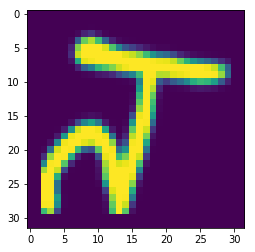

Predicted Label Class =  15
Predicted Character =  त


In [106]:
# Viewing the Devanagiri characters from the test set and their predicted labels
im = np.random.randint(0,(X_test.shape[0] - 1))
show_image(X_test[im])
print("Predicted Label Class = ",results[im])
print("Predicted Character = ",devchar[results[im]])